In [1]:
import pandas as pd
import pickle,os, copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import sys
import scipy

import re

import margin_flatness as mf
import margin_flatness.postprocessing as mf_post


%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams["figure.figsize"] = (13,9)

COLORS = plt.cm.tab20(np.arange(20))

CORRECT_COLOR_IDX = 3
INCORRECT_COLOR_IDX = 1

In [88]:
root_folder = os.environ["PATH_TO_DEEP_FOLDER"]
data_name = "MNIST"

ce_exp = "CE_F1"
ce_experiment_folder = os.path.join(root_folder, "experiments", data_name, ce_exp)

mse_exp = "MSE_F1"
mse_experiment_folder = os.path.join(root_folder, "experiments", data_name, mse_exp)


In [92]:
ce_stats_df = mf_post.stats_plotting.get_end_stats(ce_experiment_folder, step=-1)
mse_stats_df = mf_post.stats_plotting.get_end_stats(mse_experiment_folder, step=-1)


In [64]:
stats_df.sort_values(by="Acc Test Mean", ascending=False)

,Loss Test Mean,Loss Train Mean,Acc Train Mean,Acc Test Mean,Acc Gap Mean,batch_train_size,learning_rate,seed,weight_decay
1605729861.2700624,0.002310,0.000188,0.999733,0.9860,-0.013733,32,0.1,10,0
1605702831.5614505,0.002460,0.000173,0.999717,0.9860,-0.013717,32,0.1,0,0
1605733882.8815174,0.002441,0.000106,0.999817,0.9853,-0.014517,32,0.04,10,0
1605716380.9829261,0.002481,0.000194,0.999633,0.9851,-0.014533,32,0.1,5,0
1605767263.584062,0.002339,0.000171,0.999267,0.9845,-0.014767,256,0.2,0,0.0005
...,...,...,...,...,...,...,...,...,...
1605770210.8307066,0.003744,0.001703,0.990667,0.9764,-0.014267,32,0.1,0,0.0005
1605779348.659534,0.003854,0.001599,0.991667,0.9762,-0.015467,32,0.1,5,0.0005
1605775062.5808423,0.004645,0.002732,0.985583,0.9725,-0.013083,32,0.2,5,0.0005
1605784676.2389796,0.004632,0.002779,0.983100,0.9714,-0.011700,32,0.2,10,0.0005


# Plot a histogram for kendall and isotonic R^2 value. 

In [104]:
ce_all_point_traces, _ = mf.save_load.load_cached_data(ce_experiment_folder, "point_traces", step=-1, time_stamp="Dec02_14-40-03")
ce_all_point_output_margins, _ = mf.save_load.load_cached_data(ce_experiment_folder, "output_margins", step=-1, time_stamp="Dec02_20-51-39")


mse_all_point_traces, _ = mf.save_load.load_cached_data(mse_experiment_folder, "point_traces", step=-1, time_stamp="Dec02_14-40-03")
mse_all_point_output_margins, _ = mf.save_load.load_cached_data(mse_experiment_folder, "output_margins", step=-1, time_stamp="Dec02_18-53-57")


## Plot histogram Kendall 

In [106]:

num_nets = 1

ce_kendall_coeffs = {}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = ce_all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = ce_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        ce_kendall_coeffs[exp_id] = mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation

mse_kendall_coeffs = {}
for exp_id in mse_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = mse_all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = mse_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        mse_kendall_coeffs[exp_id] = mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation


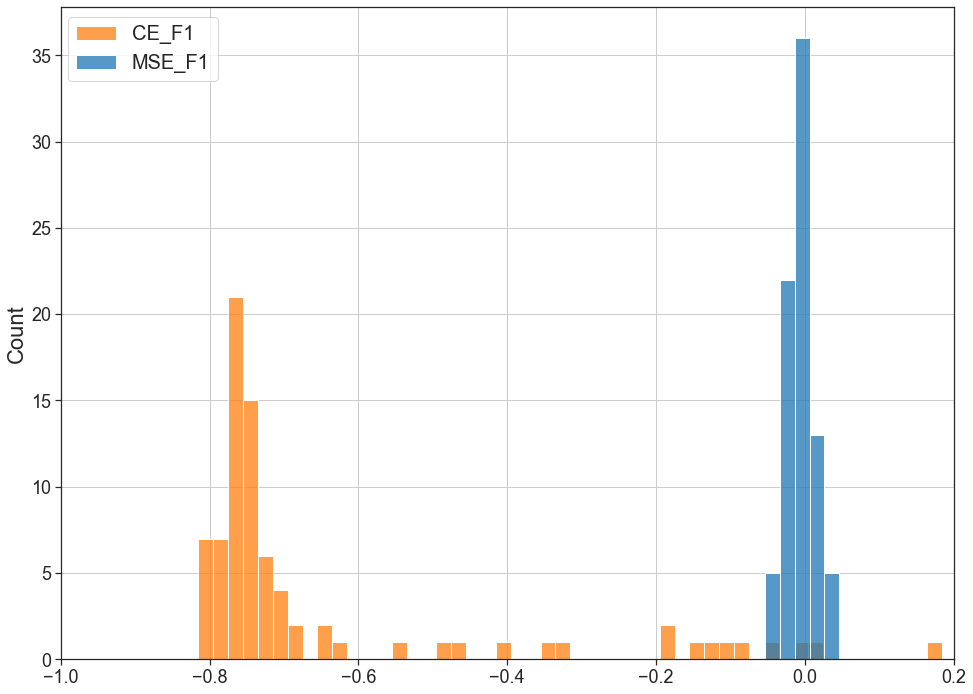

In [169]:
import seaborn as sns


sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, (ax1_hist) = plt.subplots(1, figsize=(16,12))

sns.histplot(list(ce_kendall_coeffs.values()), ax=ax1_hist, color=c1, binwidth=0.02, stat="count", label=ce_exp)
sns.histplot(list(mse_kendall_coeffs.values()), ax=ax1_hist, color=c2, binwidth=0.02, stat="count",  label=mse_exp)


ax1_hist.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1_hist.set_ylabel(ylabel="Count", fontsize=22)



# sns.despine(ax=ax1_hist)

# ax1_hist.text(x=0.97, y=0.97, transform=ax1_hist.transAxes, s="Batch Size: 256 \n Skewness: {:.2f}".format(skewness1) ,\
#          fontsize=22, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c1)

ax1_hist.set_xlim([-1, 0.2])
ax1_hist.grid(b=True, which='major')

f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.27, 0.88))



f.savefig("../figs/kendall_{}_{}_{}".format(data_name, ce_exp, mse_exp), dpi=300, bbox_inches = "tight",)

## Plot R2 of isotopic

In [410]:
num_nets = 1

ce_r2_coeffs = {}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        y_data = ce_all_point_traces[exp_id]["{}".format(nn_idx)]
        x_data = ce_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        ce_r2_coeffs[exp_id] = mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing="auto")

mse_r2_coeffs = {}
for exp_id in mse_stats_df.index:
    for nn_idx in range(num_nets):
        y_data = mse_all_point_traces[exp_id]["{}".format(nn_idx)]
        x_data = mse_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        mse_r2_coeffs[exp_id] = mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing="auto")


/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coe

/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coe

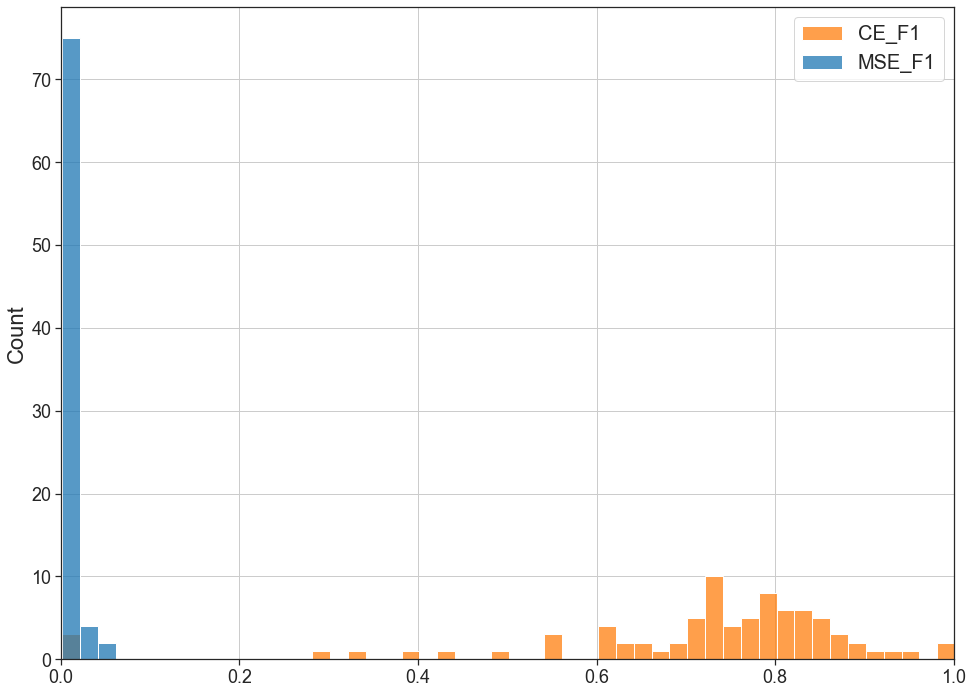

In [411]:
import seaborn as sns


sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, (ax1_hist) = plt.subplots(1, figsize=(16,12))

sns.histplot(list(ce_r2_coeffs.values()), ax=ax1_hist, color=c1, binwidth=0.02, stat="count", label=ce_exp)
sns.histplot(list(mse_r2_coeffs.values()), ax=ax1_hist, color=c2, binwidth=0.02, stat="count", label=mse_exp)


ax1_hist.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1_hist.set_ylabel(ylabel="Count", fontsize=22)



# sns.despine(ax=ax1_hist)

# ax1_hist.text(x=0.97, y=0.97, transform=ax1_hist.transAxes, s="Batch Size: 256 \n Skewness: {:.2f}".format(skewness1) ,\
#          fontsize=22, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c1)

ax1_hist.set_xlim([0, 1])
ax1_hist.grid(b=True, which='major')

f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.9, 0.88))


# f.savefig("../figs/r2_{}_{}_{}".format(data_name, ce_exp, mse_exp), dpi=300, bbox_inches = "tight",)

## Plot worst, medium and best (according to kendall)
TODO: add isotonic line

In [417]:

num_nets = 1

ce_kendall_coeffs = {}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        y_data = ce_all_point_traces[exp_id]["{}".format(nn_idx)]
        x_data = ce_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        ce_kendall_coeffs[exp_id] = mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation

mse_kendall_coeffs = {}
for exp_id in mse_stats_df.index:
    for nn_idx in range(num_nets):
        y_data = mse_all_point_traces[exp_id]["{}".format(nn_idx)]
        x_data = mse_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        mse_kendall_coeffs[exp_id] = mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation


In [418]:
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

### For CE 

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7ff775492550>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7ff77485a820>)

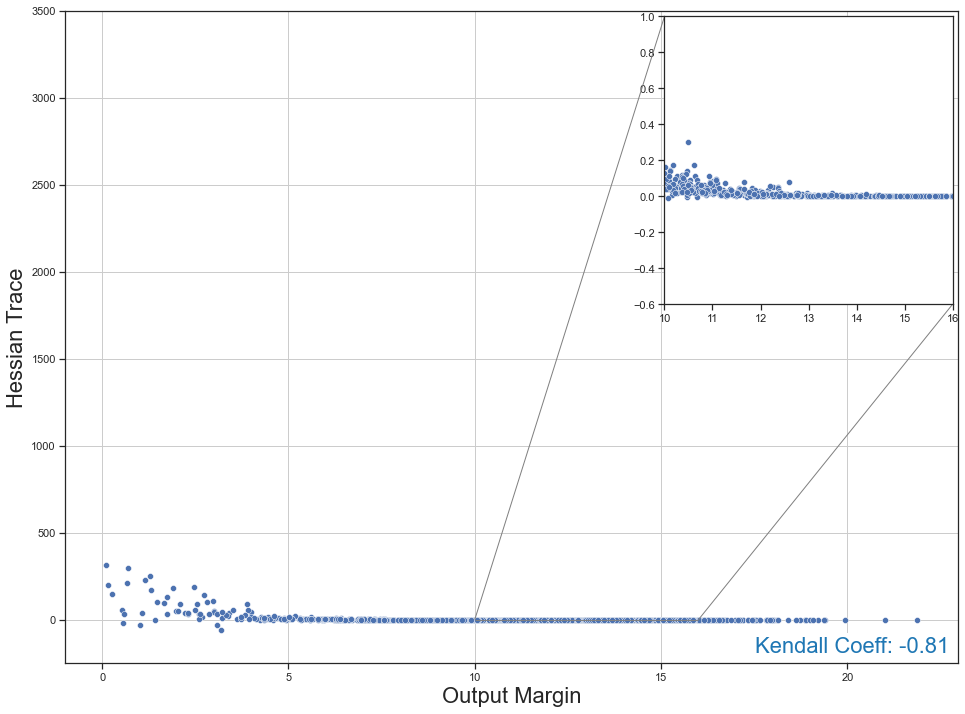

In [419]:
id_type = "best"

if id_type == "worst":
    exp_id, exp_kendall = min(ce_kendall_coeffs.items(), key=lambda kv: abs(kv[1]))
elif id_type == "best":
    exp_id, exp_kendall = max(ce_kendall_coeffs.items(), key=lambda kv: abs(kv[1]))
else:
    exp_id, exp_kendall = sorted(ce_kendall_coeffs.items(), key=lambda kv: abs(kv[1]))[len(ce_kendall_coeffs)//2]

sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(16,12))

x_data = ce_all_point_output_margins[exp_id]["0"]
y_data = ce_all_point_traces[exp_id]["0"]
sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

# ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1.set_ylabel(ylabel="Hessian Trace", fontsize=22)
ax1.set_xlabel(xlabel="Output Margin", fontsize=22)
ax1.set_ylim(-250, 3500)


ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(exp_kendall) ,\
         fontsize=22, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color=c2)

ax1.grid(b=True, which='major')

axins2 = inset_axes(ax1, width=4, height=4, loc=1)
sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# sub region of the original image
x1, x2, y1, y2 = 10, 16, -0.6, 1
axins2.set_xlim(x1, x2)
axins2.set_ylim(y1, y2)

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")


#f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.4, 0.88))


# f.savefig("../figs/subset_kendall_{}_{}_{}".format(id_type, data_name, ce_exp), dpi=300, bbox_inches = "tight",)

In [420]:
mf_post.correlation.get_isotonic_r_squared(x_data, y_data, increasing=False)

0.7254748686094702

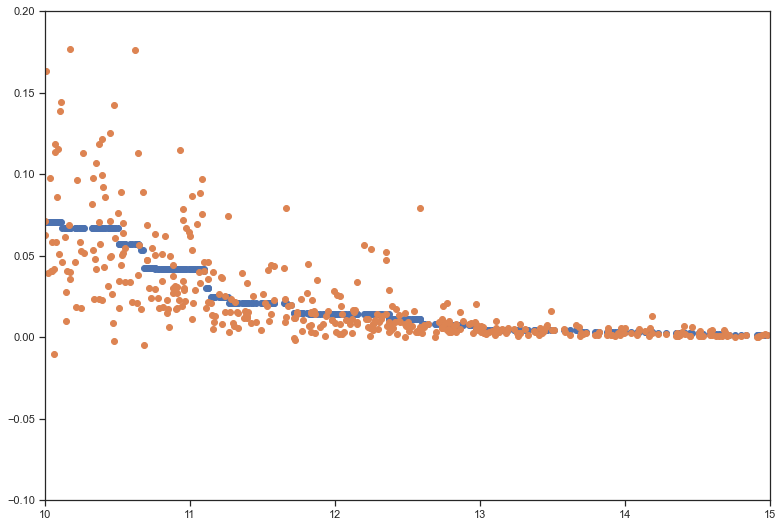

In [428]:
iso_reg = IsotonicRegression(increasing="auto").fit(x_data, y_data)
y_predicted = iso_reg.predict(x_data)
plt.scatter(x_data, y_predicted)
plt.xlim(10, 15)
plt.ylim(-0.1, 0.2)
plt.scatter(x_data, y_data)

In [421]:
mf_post.correlation.get_isotonic_r_squared(y_data, x_data, increasing='auto')

0.855672185926985

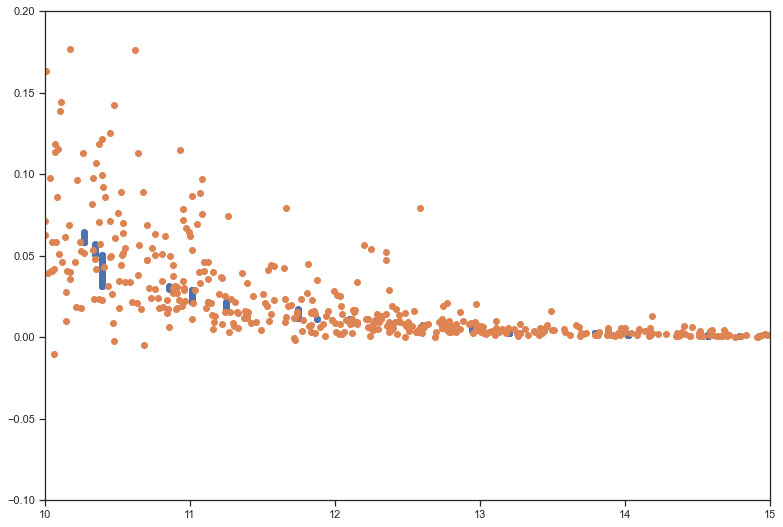

In [430]:
iso_reg = IsotonicRegression(increasing="auto").fit(y_data, x_data)
x_predicted = iso_reg.predict(y_data)
plt.xlim(10, 15)
plt.ylim(-0.1, 0.2)
plt.scatter(x_predicted, y_data)
plt.scatter(x_data, y_data)

### For MSE

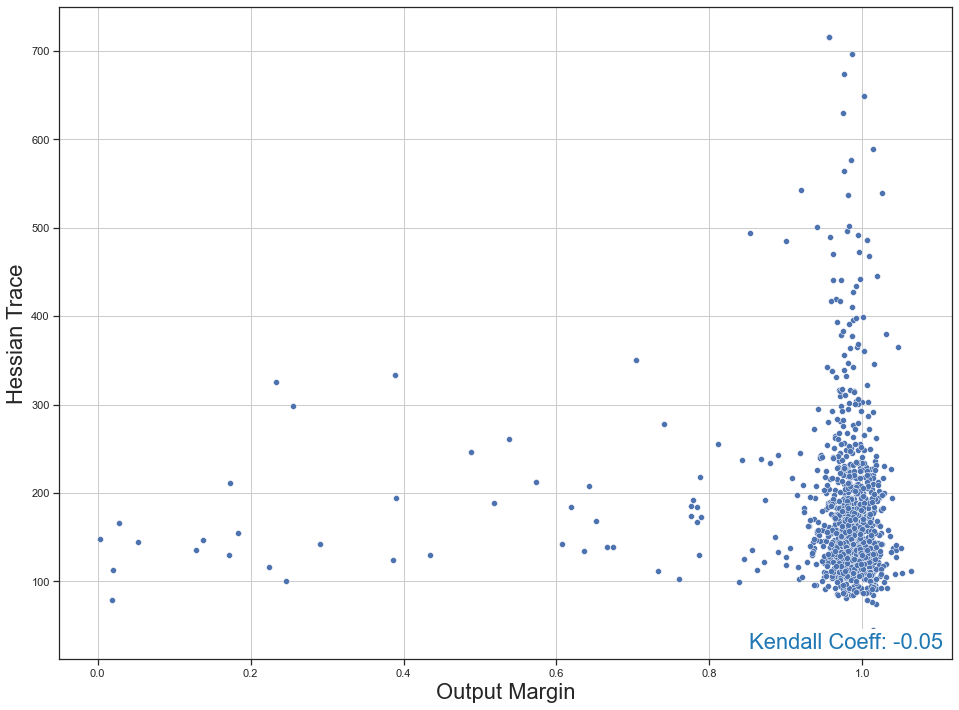

In [324]:
id_type = "best"

if id_type == "worst":
    exp_id, exp_kendall = min(mse_kendall_coeffs.items(), key=lambda kv: abs(kv[1]))
elif id_type == "best":
    exp_id, exp_kendall = max(mse_kendall_coeffs.items(), key=lambda kv: abs(kv[1]))
else:
    exp_id, exp_kendall = sorted(mse_kendall_coeffs.items(), key=lambda kv: abs(kv[1]))[len(ce_kendall_coeffs)//2]

sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(16,12))

x_data = mse_all_point_output_margins[exp_id]["0"]
y_data = mse_all_point_traces[exp_id]["0"]
sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

# ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1.set_ylabel(ylabel="Hessian Trace", fontsize=22)
ax1.set_xlabel(xlabel="Output Margin", fontsize=22)
# ax1.set_ylim(-50, 300)


ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(exp_kendall) ,\
         fontsize=22, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color=c2)

ax1.grid(b=True, which='major')

# axins2 = inset_axes(ax1, width=4, height=4, loc=2)
# sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# # sub region of the original image
# x1, x2, y1, y2 = 0.98, 1, 100, 500
# axins2.set_xlim(x1, x2)
# axins2.set_ylim(y1, y2)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")


#f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.4, 0.88))


f.savefig("../figs/subset_kendall_{}_{}_{}".format(id_type, data_name, mse_exp), dpi=300, bbox_inches = "tight",)

# Plot every point on one plot

In [337]:

num_nets = 1

ce_all_x_data = []
ce_all_y_data = []
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = ce_all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = ce_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        ce_all_x_data.append(x_data)
        ce_all_y_data.append(y_data)
#         ce_all_x_data.append(np.mean(x_data))
#         ce_all_y_data.append(np.max(y_data))
        
ce_all_x_data = np.array(ce_all_x_data).flatten()
ce_all_y_data = np.array(ce_all_y_data).flatten()
     

mse_all_x_data = []
mse_all_y_data = []
for exp_id in mse_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = mse_all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = mse_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        mse_all_x_data.append(x_data)
        mse_all_y_data.append(y_data)
#         mse_all_x_data.append(np.mean(x_data))
#         mse_all_y_data.append(np.max(y_data))
        
mse_all_x_data = np.array(mse_all_x_data).flatten()
mse_all_y_data = np.array(mse_all_y_data).flatten()
     

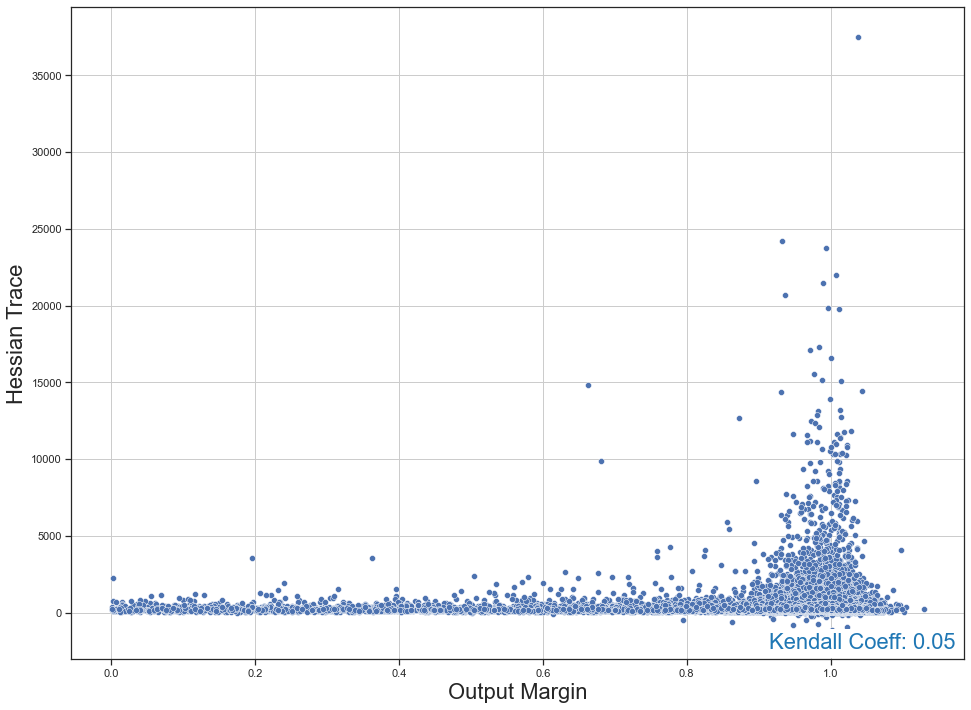

In [338]:
loss_type = "MSE"

if loss_type == "CE":
    exp_name = ce_exp
    x_data = ce_all_y_data
    y_data = ce_all_x_data
else:
    exp_name = mse_exp
    x_data = mse_all_y_data
    y_data = mse_all_x_data
    
c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(16,12))


sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

# ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1.set_ylabel(ylabel="Hessian Trace", fontsize=22)
ax1.set_xlabel(xlabel="Output Margin", fontsize=22)
# ax1.set_ylim(-50, 300)


ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(mf_post.correlation.get_kendall(all_y_data, all_x_data).correlation) ,\
         fontsize=22, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color=c2)

ax1.grid(b=True, which='major')

# axins2 = inset_axes(ax1, width=4, height=4, loc=2)
# sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# # sub region of the original image
# x1, x2, y1, y2 = 0.98, 1, 100, 500
# axins2.set_xlim(x1, x2)
# axins2.set_ylim(y1, y2)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")


#f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.4, 0.88))


f.savefig("../figs/all_points_{}_{}".format(exp_name, data_name), dpi=300, bbox_inches = "tight",)

In [76]:
mf_post.correlation.get_kendall(all_y_data, all_x_data)

KendalltauResult(correlation=0.05468215994531783, pvalue=0.48160149009640685)

In [340]:
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import r2_score
mf_post.correlation.get_isotonic_r_squared(all_y_data, all_x_data, remove_outliers=False, increasing=False)

0.10774762840929297

### Using with Isotonic Regression

In [369]:

num_nets = 1

ce_all_x_data = []
ce_all_y_data = []
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        y_data = ce_all_point_traces[exp_id]["{}".format(nn_idx)]
        x_data = ce_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        iso_reg = IsotonicRegression(increasing="auto").fit(x_data, y_data)
        y_predicted = iso_reg.predict(x_data)
        ce_all_x_data.append(y_predicted)
        ce_all_y_data.append(y_data)
#         ce_all_x_data.append(np.mean(x_data))
#         ce_all_y_data.append(np.max(y_data))
        
ce_all_x_data = np.array(ce_all_x_data).flatten()
ce_all_y_data = np.array(ce_all_y_data).flatten()
     

mse_all_x_data = []
mse_all_y_data = []
for exp_id in mse_stats_df.index:
    for nn_idx in range(num_nets):
        y_data = mse_all_point_traces[exp_id]["{}".format(nn_idx)]
        x_data = mse_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        iso_reg = IsotonicRegression(increasing="auto").fit(x_data, y_data)
        y_predicted = iso_reg.predict(x_data)
        mse_all_x_data.append(y_predicted)
        mse_all_y_data.append(y_data)
#         mse_all_x_data.append(np.mean(x_data))
#         mse_all_y_data.append(np.max(y_data))
        
mse_all_x_data = np.array(mse_all_x_data).flatten()
mse_all_y_data = np.array(mse_all_y_data).flatten()
     

/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coe

/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "


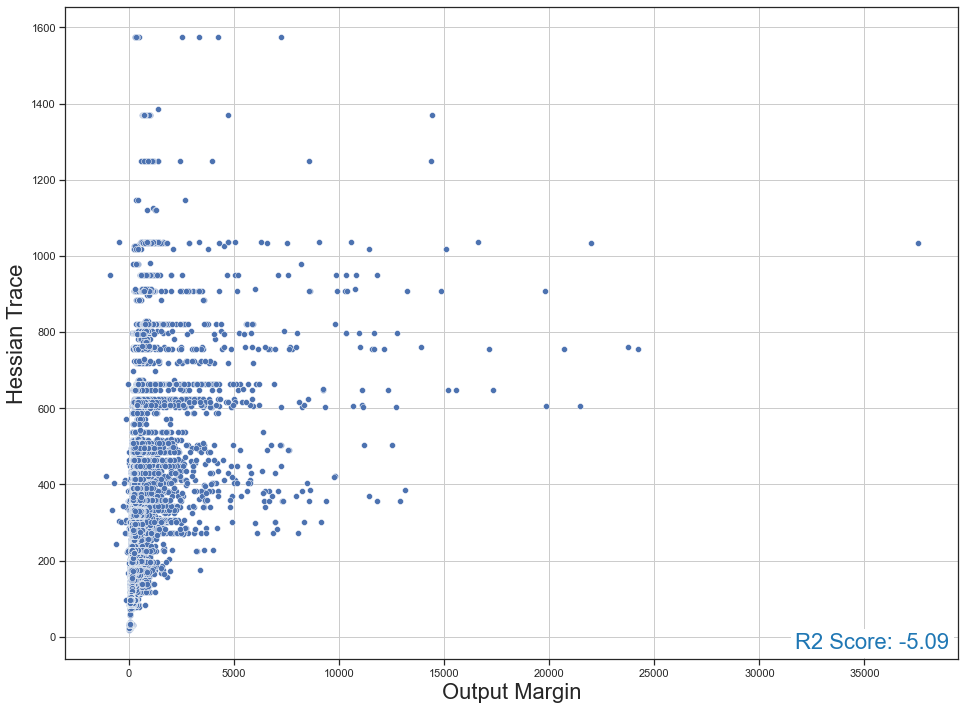

In [378]:
loss_type = "MSE"

if loss_type == "CE":
    exp_name = ce_exp
    x_data = ce_all_x_data
    y_data = ce_all_y_data
else:
    exp_name = mse_exp
    x_data = mse_all_y_data
    y_data = mse_all_x_data
    

    
c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(16,12))


sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

# ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1.set_ylabel(ylabel="Hessian Trace", fontsize=22)
ax1.set_xlabel(xlabel="Output Margin", fontsize=22)
# ax1.set_ylim(-50, 300)

# print(mf_post.correlation.get_kendall(x_data, y_data).correlation)
ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="R2 Score: {:.2f}".format(r2_score(y_data, x_data)) ,\
         fontsize=22, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color=c2)

ax1.grid(b=True, which='major')

# axins2 = inset_axes(ax1, width=4, height=4, loc=2)
# sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# # sub region of the original image
# x1, x2, y1, y2 = 0, 5000, 0, 5000
# axins2.set_xlim(x1, x2)
# axins2.set_ylim(y1, y2)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")


#f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.4, 0.88))


f.savefig("../figs/isotonic_all_points_{}_{}".format(exp_name, data_name), dpi=300, bbox_inches = "tight",)

In [375]:
print(mf_post.correlation.linregress_outliers(x_data, y_data)[2])


0.895976245627195


In [371]:
print(mf_post.correlation.get_kendall(y_data, x_data).correlation)


0.6169388147956211
